# Training at Scale

We've built a complete transformer. Now comes the hard part: *training it well*.

Two problems immediately arise when you try to train on hobby hardware:

1. **Memory constraints** force us to use small batches, which makes training noisy
2. **Overfitting** means the model memorizes training data instead of learning patterns

This notebook introduces two techniques that solve these problems: **gradient accumulation** (for stable training with limited memory) and **validation splits** (for detecting overfitting).

## The Batch Size Problem

Let's start with a fundamental question: *why does batch size matter?*

During training, we compute the loss over a "batch" of examples, then update weights based on that loss. The gradient we compute is an *estimate* of the true gradient over the entire dataset:

$$\nabla_{\text{batch}} \approx \nabla_{\text{dataset}}$$

**The statistical insight:** Larger batches give better estimates. With a batch of 8, each example contributes 12.5% of the signal. One weird example can throw off the whole gradient. With a batch of 128, each example is just 0.8%—outliers get averaged out.

| Batch Size | Gradient Noise | Training Stability |
|------------|----------------|--------------------|
| 8 | High | Erratic |
| 32 | Medium | Acceptable |
| 128 | Low | Smooth |
| 512+ | Very Low | Very smooth |

### The Memory Wall

So why not just use big batches? **Memory.**

During the forward pass, PyTorch stores *activations* at every layer (needed for backpropagation). For a transformer with:
- 6 layers, d_model=256, seq_len=128
- Each activation: (batch, seq_len, d_model) floats

Memory per example:
$$\text{Memory} \approx \text{layers} \times \text{seq\_len} \times d_{\text{model}} \times 4 \text{ bytes}$$
$$= 6 \times 128 \times 256 \times 4 = 786\text{KB per example}$$

With batch size 8: ~6 MB. With batch size 128: ~100 MB. Add attention scores, gradients, optimizer states... it adds up fast!

On a laptop with 8GB RAM, you might max out at batch size 8-16. This creates a dilemma: we *want* large batches for stability but *can't fit* them in memory.

## Gradient Accumulation: The Solution

Here's the key insight that saves us: **gradients are additive**.

If we compute gradients on two separate batches and add them together, we get the same result as computing gradients on one combined batch:

$$\nabla(L_1 + L_2) = \nabla L_1 + \nabla L_2$$

This means we can:
1. Process batch 1 → compute gradients → *don't update yet, just store*
2. Process batch 2 → compute gradients → *add to stored gradients*
3. Repeat N times
4. Finally update weights with accumulated gradients

**The result:** We simulate a batch of size $N \times \text{batch\_size}$ while only ever holding one small batch in memory.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Simple model and data for demonstration
model = nn.Linear(64, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def get_batch(batch_size=8):
    """Generate random classification data."""
    x = torch.randn(batch_size, 64)
    y = torch.randint(0, 10, (batch_size,))
    return x, y

### Standard Training (No Accumulation)

First, let's see standard training where we update after every batch:

In [3]:
print("Standard training (batch_size=8, updates every batch):")
print("="*55)

losses = []
for step in range(8):
    x, y = get_batch(batch_size=8)
    
    # Forward pass
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    # Backward pass
    loss.backward()
    
    # Update weights immediately
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.item())
    print(f"Step {step}: loss = {loss.item():.4f} → update weights")

print(f"\nLoss variance: {np.var(losses):.4f} (high = noisy training)")

Standard training (batch_size=8, updates every batch):
Step 0: loss = 2.8670 → update weights
Step 1: loss = 2.4275 → update weights
Step 2: loss = 2.1647 → update weights
Step 3: loss = 2.6930 → update weights
Step 4: loss = 2.5277 → update weights
Step 5: loss = 2.6354 → update weights
Step 6: loss = 2.1532 → update weights
Step 7: loss = 2.6031 → update weights

Loss variance: 0.0549 (high = noisy training)


### Training with Gradient Accumulation

Now let's accumulate gradients over 4 batches before updating. This simulates an effective batch size of 32 (4 × 8):

In [4]:
# Reset model
model = nn.Linear(64, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

accumulation_steps = 4  # Accumulate over 4 mini-batches
batch_size = 8
effective_batch_size = accumulation_steps * batch_size  # = 32

print(f"Gradient accumulation (batch_size={batch_size}, accumulation_steps={accumulation_steps}):")
print(f"Effective batch size: {effective_batch_size}")
print("="*55)

accumulated_losses = []
optimizer.zero_grad()  # Start with zero gradients

for step in range(8):
    x, y = get_batch(batch_size=8)
    
    # Forward pass
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    # CRITICAL: Scale loss by accumulation steps!
    # This ensures the final gradient magnitude matches a true large batch
    scaled_loss = loss / accumulation_steps
    scaled_loss.backward()  # Gradients accumulate (add to existing)
    
    accumulated_losses.append(loss.item())
    
    # Only update every accumulation_steps batches
    if (step + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients for next accumulation
        avg_loss = np.mean(accumulated_losses[-accumulation_steps:])
        print(f"Step {step}: avg_loss = {avg_loss:.4f} → update weights")
    else:
        print(f"Step {step}: loss = {loss.item():.4f} → accumulating...")

Gradient accumulation (batch_size=8, accumulation_steps=4):
Effective batch size: 32
Step 0: loss = 2.6713 → accumulating...
Step 1: loss = 2.2812 → accumulating...
Step 2: loss = 2.7019 → accumulating...
Step 3: avg_loss = 2.4725 → update weights
Step 4: loss = 2.6787 → accumulating...
Step 5: loss = 2.6121 → accumulating...
Step 6: loss = 2.5706 → accumulating...
Step 7: avg_loss = 2.5733 → update weights


### Why Scale the Loss?

Notice we divided the loss by `accumulation_steps`. Here's why:

With a single batch of size $B$, the loss is typically averaged:
$$L = \frac{1}{B} \sum_{i=1}^{B} \ell_i$$

If we accumulate over $N$ batches without scaling:
$$L_{\text{accumulated}} = \sum_{j=1}^{N} \frac{1}{B} \sum_{i=1}^{B} \ell_{ij} = \frac{N}{B} \sum_{\text{all}} \ell$$

That's $N$ times too large! The gradients would be $N$ times what they'd be with a true batch of size $N \times B$.

By dividing each loss by $N$, we get:
$$L_{\text{correct}} = \frac{1}{N \cdot B} \sum_{\text{all}} \ell$$

Which is exactly the average over all $N \cdot B$ examples.

## Validation: Detecting Overfitting

Now for the second problem: how do we know if our model is actually *learning* vs. just *memorizing*?

### The Memorization Problem

Imagine a student preparing for an exam:
- **Memorization:** They memorize exact answers to practice problems. On the exam, they fail because the questions are slightly different.
- **Understanding:** They learn the underlying concepts. On the exam, they can solve new variations.

Neural networks face the same challenge. A model might achieve 0% error on training data by "memorizing" each example, yet fail completely on new data. This is **overfitting**.

### The Validation Split

The solution is simple: **hold out some data the model never sees during training**.

| Split | Purpose | Model Sees It? |
|-------|---------|----------------|
| Training (90%) | Learning weights | Yes, repeatedly |
| Validation (10%) | Monitoring generalization | Never during training |

After each epoch, we evaluate on the validation set. If the model is truly learning patterns (not memorizing), it should perform well on *both* sets.

### Interpreting Training Curves

By plotting training loss and validation loss over time, we can diagnose what's happening:

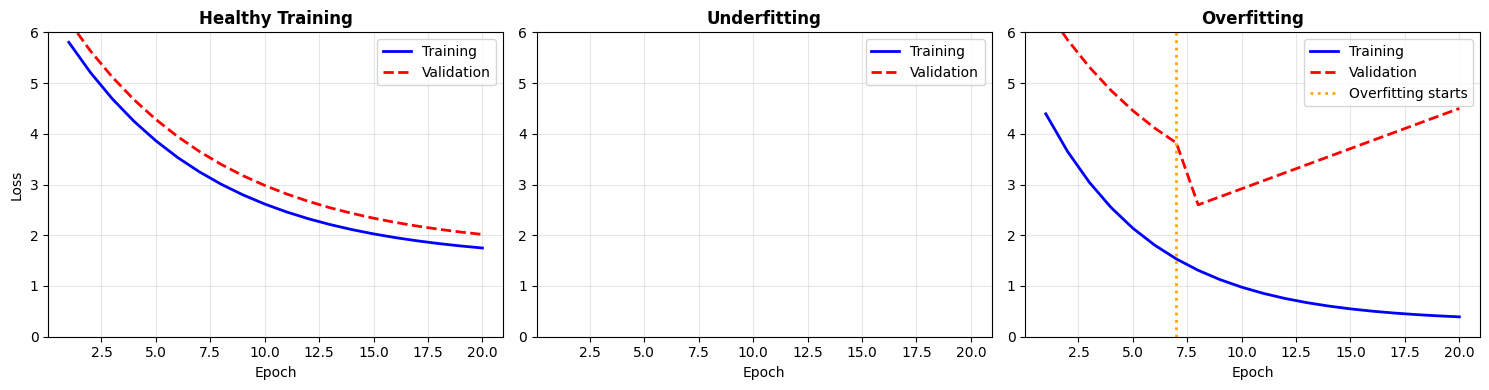

In [5]:
epochs = np.arange(1, 21)

# Scenario 1: Healthy training (both losses decrease together)
train_healthy = 5.0 * np.exp(-0.15 * epochs) + 1.5
val_healthy = 5.2 * np.exp(-0.14 * epochs) + 1.7

# Scenario 2: Underfitting (both losses stay high)
train_underfit = 5.0 * np.exp(-0.03 * epochs) + 3.5
val_underfit = 5.2 * np.exp(-0.025 * epochs) + 3.8

# Scenario 3: Overfitting (validation rises while training falls)
train_overfit = 5.0 * np.exp(-0.2 * epochs) + 0.3
val_overfit = np.concatenate([
    5.2 * np.exp(-0.15 * epochs[:7]) + 2.0,
    np.linspace(2.6, 4.5, 13)
])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Healthy
axes[0].plot(epochs, train_healthy, 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, val_healthy, 'r--', label='Validation', linewidth=2)
axes[0].set_title('Healthy Training', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 6)

# Underfitting
axes[1].plot(epochs, train_underfit, 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, val_underfit, 'r--', label='Validation', linewidth=2)
axes[1].set_title('Underfitting', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 6)

# Overfitting
axes[2].plot(epochs, train_overfit, 'b-', label='Training', linewidth=2)
axes[2].plot(epochs, val_overfit, 'r--', label='Validation', linewidth=2)
axes[2].axvline(x=7, color='orange', linestyle=':', linewidth=2, label='Overfitting starts')
axes[2].set_title('Overfitting', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 6)

plt.tight_layout()
plt.show()

### Diagnostic Guide

| Pattern | Diagnosis | Solution |
|---------|-----------|----------|
| Both losses decrease together | Healthy | Keep training |
| Both losses stay high | Underfitting | Larger model, more training |
| Train ↓, Val ↑ | Overfitting | More data, regularization, early stopping |
| Large gap (train << val) | Overfitting | Same as above |
| Training loss spikes | Unstable | Lower learning rate |

## Complete Training Loop

Let's put it all together—a training loop with gradient accumulation and validation monitoring:

In [6]:
def train_with_validation(
    model,
    train_data,
    val_data,
    optimizer,
    epochs,
    accumulation_steps=1,
    device='cpu'
):
    """
    Training loop with gradient accumulation and validation.
    
    Args:
        model: The transformer model
        train_data: DataLoader for training set
        val_data: DataLoader for validation set
        optimizer: Optimizer (e.g., AdamW)
        epochs: Number of training epochs
        accumulation_steps: Number of batches to accumulate
        device: 'cpu' or 'cuda'
    
    Returns:
        Dictionary with training history
    """
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # ===== Training Phase =====
        model.train()  # Enable dropout, batch norm training mode
        train_loss = 0
        num_batches = 0
        optimizer.zero_grad()
        
        for step, (x, y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            
            # Scale and accumulate gradients
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()
            
            train_loss += loss.item()
            num_batches += 1
            
            # Update weights every accumulation_steps batches
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        
        # Handle remaining gradients if batches don't divide evenly
        if num_batches % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        avg_train_loss = train_loss / num_batches
        history['train_loss'].append(avg_train_loss)
        
        # ===== Validation Phase =====
        model.eval()  # Disable dropout, use running stats for batch norm
        val_loss = 0
        num_val_batches = 0
        
        with torch.no_grad():  # No gradient computation (faster, saves memory)
            for x, y in val_data:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = F.cross_entropy(logits, y)
                val_loss += loss.item()
                num_val_batches += 1
        
        avg_val_loss = val_loss / num_val_batches
        history['val_loss'].append(avg_val_loss)
        
        # Report progress
        print(f"Epoch {epoch+1}/{epochs}: "
              f"train_loss={avg_train_loss:.4f}, "
              f"val_loss={avg_val_loss:.4f}")
        
        # Early warning for overfitting
        if len(history['val_loss']) > 1:
            if history['val_loss'][-1] > history['val_loss'][-2] * 1.05:
                print("  ⚠️  Warning: validation loss increased!")
    
    return history

In [7]:
# Demonstrate the training loop structure
print("Training Loop Structure:")
print("="*50)
print("""
for epoch in range(epochs):
    
    # 1. TRAINING PHASE
    model.train()              # Enable training mode
    optimizer.zero_grad()      # Clear old gradients
    
    for step, batch in enumerate(train_data):
        loss = compute_loss(model, batch)
        (loss / accum_steps).backward()  # Accumulate
        
        if (step + 1) % accum_steps == 0:
            optimizer.step()   # Update weights
            optimizer.zero_grad()
    
    # 2. VALIDATION PHASE
    model.eval()               # Disable training mode
    
    with torch.no_grad():      # No gradients needed
        for batch in val_data:
            loss = compute_loss(model, batch)
            # Just record loss, don't update anything
    
    # 3. MONITOR AND LOG
    print(f"Epoch {epoch}: train={train_loss}, val={val_loss}")
""")

Training Loop Structure:

for epoch in range(epochs):

    # 1. TRAINING PHASE
    model.train()              # Enable training mode
    optimizer.zero_grad()      # Clear old gradients

    for step, batch in enumerate(train_data):
        loss = compute_loss(model, batch)
        (loss / accum_steps).backward()  # Accumulate

        if (step + 1) % accum_steps == 0:
            optimizer.step()   # Update weights
            optimizer.zero_grad()

    # 2. VALIDATION PHASE
    model.eval()               # Disable training mode

    with torch.no_grad():      # No gradients needed
        for batch in val_data:
            loss = compute_loss(model, batch)
            # Just record loss, don't update anything

    # 3. MONITOR AND LOG
    print(f"Epoch {epoch}: train={train_loss}, val={val_loss}")



## Important Details

### model.train() vs model.eval()

These mode switches matter for:
- **Dropout:** Randomly zeros neurons during training (regularization), but we want deterministic predictions during validation
- **Batch Normalization:** Uses batch statistics during training, running statistics during eval

Always use `model.train()` before training and `model.eval()` before validation!

### torch.no_grad()

During validation, we don't need gradients—we're just measuring performance, not updating weights. `torch.no_grad()` tells PyTorch to skip gradient computation, which:
- Runs faster (no backward graph construction)
- Uses less memory (no activation storage)

## Practical Recommendations

Based on typical hobby hardware (8-16GB RAM, consumer GPU or Apple Silicon):

| Parameter | Recommended | Notes |
|-----------|-------------|-------|
| Batch size | 8-16 | Whatever fits in memory |
| Accumulation steps | 8-16 | Effective batch 64-256 |
| Validation split | 10% | Or 5% for large datasets |
| Early stopping patience | 3-5 epochs | Stop if val loss doesn't improve |

**Memory-compute tradeoff:** If you have more memory, use larger batches (faster). If memory is tight, use more accumulation steps (same quality, slower).

**Effective improvements:**
- 20-30% lower final loss from stable gradients
- Smoother training curves, easier debugging
- Confidence that your model generalizes
- Works on commodity hardware!

## Summary

| Technique | Problem Solved | How It Works |
|-----------|---------------|---------------|
| Gradient Accumulation | Small batches → noisy training | Accumulate gradients over N batches, then update |
| Validation Split | Can't detect overfitting | Hold out data to test generalization |

**Key formulas:**

Gradient accumulation (scale loss):
$$L_{\text{scaled}} = \frac{L}{N} \quad \text{where } N = \text{accumulation steps}$$

Effective batch size:
$$B_{\text{effective}} = B_{\text{micro}} \times N$$

## Next: KV-Cache

Training teaches the model what to predict. But how do we actually *generate* text efficiently? The naive approach recomputes everything for each token—wasteful! Next, we'll see how **KV-caching** makes generation fast by reusing previous computations.